# Convolutional Collaborative Filtering

In [1]:
import numpy as np
import pandas as pd
import gensim
from string import punctuation
from collections import Counter

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import pickle

import models.model_cdl_conf_mf
import models.dataset

from sklearn.metrics import mean_squared_error, mean_absolute_error
from helpful_stuff.utils_xp_out import write_to_csv, XPDescription, XPResults
from helpful_stuff.utils_metrics import precision_recall_at_k_4arrays
from helpful_stuff.utils_model_out import make_out_dirs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from importlib import reload
reload(models.dataset)
reload(models.model_cdl_conf_mf)

Using TensorFlow backend.


<module 'models.model_cdl_conf_mf' from 'C:\\Users\\irina\\Dev\\master\\models\\model_cdl_conf_mf.py'>

In [2]:
# make useful dirs
XP_PATH, U_V_PATH, MODEL_PATH = make_out_dirs(model_name='sdae-sgd', xp_name='goodreads_test_1') 
print("Out dir of experiment: ", XP_PATH)
print("Out dir of U, V matricies: ", U_V_PATH)
print("Out dir of model parameters: ", MODEL_PATH)

Out dir of experiment:  D:/Models/thesis/sdae-sgd/goodreads_test_1/
Out dir of U, V matricies:  D:/Models/thesis/sdae-sgd/goodreads_test_1/pickles/
Out dir of model parameters:  D:/Models/thesis/sdae-sgd/goodreads_test_1/tf/


### Load review texts

In [3]:
df_rev = pd.read_json('D:/Datasets/goodreads_reviews/processed/goodreads_reviews_children.json')

,book_id,date_added,date_updated,n_comments,n_votes,rating,read_at,review_id,review_text,review_text_proc,started_at,user_id
0,23310161,Tue Nov 17 11:37:35 -0800 2015,Tue Nov 17 11:38:05 -0800 2015,0,7,4,,f4b4b050f4be00e9283c92a814af2670,Fun sequel to the original.,fun sequel original,,8842281e1d1347389f2ab93d60773d4d
1,17290220,Sat Nov 08 08:54:03 -0800 2014,Wed Jan 25 13:56:12 -0800 2017,0,4,5,Tue Jan 24 00:00:00 -0800 2017,22d424a2b0057b18fb6ecf017af7be92,One of my favorite books to read to my 5 year ...,one favorite book read 5 year old rosie learn ...,,8842281e1d1347389f2ab93d60773d4d


In [4]:
reviews = df_rev.groupby('book_id').review_text_proc.agg(' '.join)
reviews = pd.DataFrame(reviews)
reviews = reviews.reset_index()

In [5]:
reviews.head(2)

,book_id,review_text_proc
0,5,i think i enjoy reread book 3 i enjoy book tim...
1,50,i not survival story brian real i completely w...


### Tokenize and pad reviews

In [6]:
tokenizer = Tokenizer() # nb_words=MAX_NB_WORDS
tokenizer.fit_on_texts(reviews.review_text_proc)
review_sequences = tokenizer.texts_to_sequences(reviews.review_text_proc)

In [7]:
print("Num of train texts: %s" % len(review_sequences))
print("Example of sequence: ", review_sequences[10][1:15], '...')

Num of train texts: 123946
Example of sequence:  [1799, 3491, 519, 519, 149, 83711, 22, 909, 2132, 4513, 60385, 1192, 1678, 54104] ...


In [8]:
review_lengths = [len(s) for s in review_sequences]
review_lengths_clean = [i for i in review_lengths if i < 5000]

In [9]:
print("Num of texts including long %s and excluding long ones %s" % (len(review_lengths), len(review_lengths_clean)))
print("Text lengths: max=%s, min=%s, mean=%s" % (max(review_lengths_clean), min(review_lengths_clean), np.mean(review_lengths_clean)))

Num of texts including long 123946 and excluding long ones 123442
Text lengths: max=4975, min=0, mean=196.3401192462857


C:\Users\irina\Miniconda3\envs\exmc\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


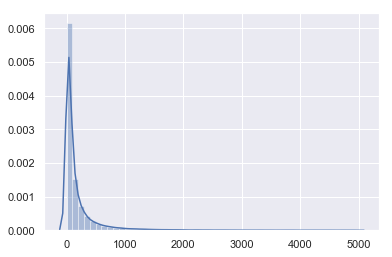

In [10]:
sns.distplot(review_lengths_clean)

In [11]:
padded_review_sequences = pad_sequences(review_sequences, maxlen=5000)

In [12]:
print('Shape of padded review Sequences: ', padded_review_sequences.shape)

Shape of padded review Sequences:  (123946, 5000)


In [13]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Indexes of common words: you = %s, the = %s, it = %s.' % (word_index['you'], word_index['the'], word_index['it']))

Found 407858 unique tokens.
Indexes of common words: you = 155, the = 5, it = 13.


In [14]:
sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[0:20]

[('i', 1190055),
 ('book', 845962),
 ('read', 418021),
 ('story', 364450),
 ('the', 358569),
 ('be', 348115),
 ("'s", 314218),
 ('not', 310999),
 ('love', 250647),
 ('like', 232436),
 ('child', 219737),
 ('this', 216768),
 ('it', 193538),
 ('good', 180733),
 ('kid', 144785),
 ('little', 140345),
 ('think', 139538),
 ('time', 136750),
 ('great', 132831),
 ('illustration', 120242)]

In [15]:
reviews['padded_review_seq'] = padded_review_sequences.tolist()

In [17]:
reviews.head(2)

,book_id,review_text_proc,padded_review_seq
0,5,i think i enjoy reread book 3 i enjoy book tim...,"[448, 1, 3, 2, 18, 155, 30, 448, 155, 30, 1, 8..."
1,50,i not survival story brian real i completely w...,"[17, 1, 3, 32, 419, 50, 106, 12, 2, 8, 228, 1,..."


### Prepare embedding matrix

In [18]:
# Loading Word2Vec
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('D:/Datasets/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [19]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
missed_words = Counter()

for word, i in word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = np.array(w2v_model[word])
    else:
        missed_words[word] += 1
        embedding_matrix[i] = np.random.rand(1, EMBEDDING_DIM)[0]

embedding_matrix = embedding_matrix.astype('float32')

In [20]:
print(len(missed_words))
missed_words.most_common(10)

341968


[('pienempana', 1),
 ('yakuwnu', 1),
 ('heddis', 1),
 ('jeogeul', 1),
 ('garfio', 1),
 ('tooni', 1),
 ('rationalitat', 1),
 ('znaiomoiu', 1),
 ('zbor', 1),
 ('fijarse', 1)]

### Prepare dataset

In [21]:
df_rates = pd.read_json('D:/Datasets/goodreads_reviews/processed/goodreads_interactions_children.json')
df_rates.head(2)

,book_id,rating,user_id
0,23310161,4,8842281e1d1347389f2ab93d60773d4d
1,18296097,5,8842281e1d1347389f2ab93d60773d4d
10,460548,5,8842281e1d1347389f2ab93d60773d4d
100,24000713,5,fe0df2eff573e75c036eb8287c6b012a
1000,113946,5,0d8d07544717e84149df654caae803d0


In [22]:
reviews = reviews.drop('review_text_proc', axis=1)

In [23]:
ds = models.dataset.DataSet(df_ratings=df_rates, rating_cols=['user_id', 'book_id', 'rating'], 
                            df_reviews=reviews, review_cols=['book_id', 'padded_review_seq'],
                            vectorize_reviews=False, empty_element=np.zeros(5000))

Filled in 135 empty reviews: [2817, 127768, 193412, 194874, 265833]...


In [24]:
del reviews, df_rates, df_rev, w2v_model, missed_words, padded_review_sequences, word_index, review_lengths, review_lengths_clean

### Train model

In [25]:
%reset Out 
tf.reset_default_graph()

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Flushing output cache (9 entries)


In [ ]:
cdl = models.model_cdl_conf_mf.ConvolutionalCDL(embedding_matrix, ds,
                              out_path=XP_PATH, projection_dim=50, vanilla_dim=250, num_filters = 50, 
                              drop_ratio=0.2, epochs=60, 
                              lambda_w=1, lambda_v=1, lambda_q = 10)
mu, pu, qi, bu, bi = cdl.training() 

Shape of embed texts:  (?, 50)
Shape of V:  Tensor("Placeholder_3:0", shape=(?, 50), dtype=float32)
Trainable params
[TensorShape([Dimension(3), Dimension(300), Dimension(1), Dimension(50)]), TensorShape([Dimension(50)]), TensorShape([Dimension(3), Dimension(300), Dimension(1), Dimension(50)]), TensorShape([Dimension(50)]), TensorShape([Dimension(4), Dimension(300), Dimension(1), Dimension(50)]), TensorShape([Dimension(50)]), TensorShape([Dimension(5), Dimension(300), Dimension(1), Dimension(50)]), TensorShape([Dimension(50)]), TensorShape([Dimension(150), Dimension(250)]), TensorShape([Dimension(250)]), TensorShape([Dimension(250), Dimension(50)]), TensorShape([Dimension(50)])]
Start training...
EPOCH 1 / 60: 
Initial embedding completed:  (123196, 50)


............................................................................................................................

............................................................................................................

In [ ]:
## dump U and V matricies to pickle files
print("pu shape: %s x %s" % pu.shape)
print("qi shape: %s x %s" % qi.shape)

print("beta_u shape: %s" % bu.shape)
print("beta_i shape: %s" % bi.shape)

with open(U_V_PATH + 'mx.pickle', 'wb') as handle:
    pickle.dump({'mu':mu, 'pu':pu, 'qi':qi, 'bu':bu, 'bi':bi}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(U_V_PATH + 'item_ids_map.pickle', 'wb') as handle:
    pickle.dump(ds., handle, protocol=pickle.HIGHEST_PROTOCOL)

### Evaluate model

In [ ]:
test_preds = models.mf_sgd.SGD.predict_dataset_with_params(ds.get_test_rating_matrix(), mu, bu, bi, qi, pu)

In [ ]:
mse = mean_squared_error(ds.testset.rate__, test_preds) ** 0.5
mae = mean_absolute_error(ds.testset.rate__, test_preds)

print("MSE: %s" % mse)
print("MAE: %s" % mae)

In [ ]:
k_prec = {}
k_rec = {}

for k in range(0, 200):
    precisions, recalls = precision_recall_at_k_4arrays(ds.testset.uid__, test_preds, ds.testset.rate__, k=k, threshold=3) 
    p_mean = np.mean(list(precisions.values()))
    r_mean = np.mean(list(recalls.values()))
    k_prec[k] = p_mean
    k_rec[k] = r_mean

In [ ]:
row = XPResults(dataset='Goodreads_Kids', xpdata=XPDescription(predictor=None, label='CDL-SDAE-SGD', nfactors=25), rmse=mse, mae=mae, precision=k_prec, recall=k_rec)

In [ ]:
write_to_csv(row, 'goodreads', 'conv_mf_sgd_optim')